## MLPs with PyTorch

### **1. From Manual Networks to PyTorch – Why Abstract?**

In the last notebook, we **manually implemented**:

- A feedforward neural network (FNN)
- A forward pass to compute predictions
- A backward pass using the chain rule
- Weight updates using **Stochastic Gradient Descent (SGD)**

✅ That helped us build **intuition** for how neural networks learn.

But as we scale up...

> 💡 Real-world models have:
> - Many layers and neurons
> - Millions of weights
> - Complex loss functions
> - Multiple datasets and devices
> - The need for rapid experimentation

Manually coding all that becomes:

❌ Tedious  
❌ Error-prone  
❌ Slow to iterate

**What PyTorch Automates For Us**

| Task                         | Manual (NB03)     | PyTorch (NB04)        |
|------------------------------|-------------------|------------------------|
| Forward pass                 | You wrote it      | Handled by `nn.Module` |
| Gradient computation         | You derived it    | Handled by `autograd`  |
| Weight update (SGD)          | You coded it      | Handled by `optimizer.step()` |
| Loss calculation             | You used MSE      | We’ll use `BCELoss` / `BCEWithLogitsLoss` |
| Batch handling / vector ops  | You looped        | Efficient tensor ops   |


**The Philosophy of Using Frameworks**

We don’t use PyTorch because we *can’t* do it ourselves —  
we use it because it lets us focus on **designing**, **training**, and **improving** models — not on reinventing gradient mechanics.


**What We'll Do in This Notebook**

Now, we’ll build a similar FNN using PyTorch tools:

- Load and preprocess the **Heart Disease dataset**
- Define a model using `nn.Module` or `nn.Sequential`
- Train it using `BCEWithLogitsLoss` and `Adam` optimizer
- Evaluate performance and visualize results

**What You'll Learn**

- How to define a deep learning model with PyTorch
- How to preprocess real-world tabular data
- How to train, monitor, and evaluate a binary classifier
- How to bridge theory → practice

---

In [1]:
import pandas as pd
import numpy as np

In [2]:


data = pd.read_csv('heart.csv')
print(data.shape)

(303, 14)


In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Check for Missing Values**

In [4]:
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
data['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [6]:
np.bincount(data['target'])

array([138, 165])

**Select Features**

We’ll use **all 13 input columns** (excluding the original `num`),  
and predict the new `target`.

In [7]:
X = data.drop('target', axis=1)
y = data['target']

**Normalize the Input Features**

To improve training, we **standardize** input features (mean = 0, std = 1).

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
import torch
from sklearn.model_selection import train_test_split

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tesnor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tesnor, test_size=0.2, random_state=42)


✅ We now have a fully cleaned, scaled, and split dataset — ready to be used in a PyTorch model!

➡️ In the next section, we’ll define our **Feedforward Neural Network** model architecture using `nn.Sequential`.

---

### **3. Defining the Model using `nn.Sequential`**

Now that we’ve prepared our dataset, let’s define a **Feedforward Neural Network (FNN)** using PyTorch.

**Architecture Overview**

We’ll build a simple network:

- Input: 13 features (from the dataset)
- Hidden layer: 16 neurons with ReLU activation
- Output: 1 neuron (for binary prediction)

📝 We’ll use **`nn.Sequential`** to define this model concisely.

In [10]:
X_train.shape[1]

13

**Define FNN with `nn.Sequential`**

In [11]:
import torch.nn as nn
import torch.optim as optim

# define model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=13, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
  (3): Sigmoid()
)


**Why `Sigmoid` at the Output?**

- Because we want the model’s output to be a **probability** between 0 and 1.
- This matches with the **binary target labels** (0 or 1).
- We’ll later use **`BCELoss`** which expects probabilities.

**Parameter Count**

- Layer 1 (Linear 13 → 16): 13 × 16 weights + 16 biases = 224
- Layer 2 (Linear 16 → 1): 16 weights + 1 bias = 17
- **Total trainable parameters** = 241

➡️ You can confirm this using:

In [12]:
sum(p.numel() for p in model.parameters())

241

**Summary**

- Defined a 2-layer FNN with ReLU and Sigmoid
- Chose `nn.Sequential` for clarity and simplicity

➡️ Next, we’ll define the **loss function and optimizer** to begin training.

---

## 🔧 Code Task 2.4.3.1: Define a Custom Feedforward Neural Network with PyTorch

Now that you’ve seen how to build a basic `nn.Sequential` model in PyTorch, let’s build a slightly different architecture.

Your Task:

- Define a feedforward neural network using `nn.Sequential`
- This model should have:
  - Input layer: 13 features (same as the heart disease dataset)
  - **Two hidden layers**:
    - First hidden layer: 32 units, followed by a **LeakyReLU** activation
    - Second hidden layer: 16 units, followed by a **Sigmoid** activation
  - Output layer: 1 neuron, followed by a **Sigmoid** activation (for binary classification)

🧠 Notes:
- Use `nn.LeakyReLU()` and `nn.Sigmoid()` activations.
- Use `print(model)` to display your model.

🎯 Final variable name: `custom_model`


In [13]:
custom_model = nn.Sequential(
    nn.Linear(13, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 16),
    nn.Sigmoid(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

print(custom_model)

sum(p.numel() for p in custom_model.parameters())

Sequential(
  (0): Linear(in_features=13, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)


993

### **4. Loss Function and Optimizer**

Now that we have defined our FNN model, we need to specify **how the model learns** from the data.

This requires:

1. A **loss function**: to measure the model's prediction error  
2. An **optimizer**: to update the model’s weights using gradients

**Loss Function: `nn.BCELoss`**

We are doing **binary classification**, so we’ll use the Binary Cross-Entropy function, also known as the log loss function

In [14]:
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

**Why `BCELoss`?**

- It expects model outputs to be **probabilities** (which we get from `Sigmoid`)
- It compares predicted probabilities with true binary labels (0 or 1)

**Optimizer: `torch.optim.Adam`**

For training the model, we use the **Adam** optimizer:

**Why `Adam`?**

- Adaptive learning rate for each parameter
- Generally works well as a default choice
- Less sensitive to initial learning rate

### **What Happens Behind the Scenes?**

1. The model makes a prediction: $\hat{y}$  
2. The loss compares $\hat{y}$ with the true label $y$  
3. Gradients are computed via **backpropagation**  
4. The optimizer updates the weights to reduce the loss

We’ll soon put all this together in the **training loop**.

➡️ Let’s now write the full **training loop** to train our FNN on the dataset.

---

### **5. Training the Model (Looping Over Epochs)**

Now that we have:

- ✅ Defined our model (`nn.Sequential`)
- ✅ Chosen a loss function (`BCELoss`)
- ✅ Configured the optimizer (`Adam`)

…it’s time to **train the model** using the **forward → loss → backward → update** cycle.

**Training Steps Recap:**

For each epoch:

1. **Forward pass** → Compute predictions from input features
2. **Loss computation** → How far are we from the true labels?
3. **Backward pass** → Compute gradients w.r.t. weights
4. **Parameter update** → Optimizer steps in and adjusts weights
5. **Zero gradients** → Reset before the next epoch

**Epochs and Tracking Loss**

- We’ll train for **100 epochs**
- Store all training losses in a Python list
- Print loss every **10 epochs** to monitor progress

### Training Loop

In [15]:
num_epochs = 200
train_loss = []

for epoch in range(num_epochs):
    # set model in train mode
    model.train()

    # forward pass
    output = model(X_train)
    loss = loss_fn(output, y_train)
    train_loss.append(loss.item())

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/200], Loss: 0.4919
Epoch [20/200], Loss: 0.3820
Epoch [30/200], Loss: 0.3301
Epoch [40/200], Loss: 0.3032
Epoch [50/200], Loss: 0.2815
Epoch [60/200], Loss: 0.2628
Epoch [70/200], Loss: 0.2436
Epoch [80/200], Loss: 0.2230
Epoch [90/200], Loss: 0.2022
Epoch [100/200], Loss: 0.1826
Epoch [110/200], Loss: 0.1643
Epoch [120/200], Loss: 0.1465
Epoch [130/200], Loss: 0.1295
Epoch [140/200], Loss: 0.1129
Epoch [150/200], Loss: 0.0974
Epoch [160/200], Loss: 0.0830
Epoch [170/200], Loss: 0.0709
Epoch [180/200], Loss: 0.0609
Epoch [190/200], Loss: 0.0525
Epoch [200/200], Loss: 0.0452


**Why Are We Doing This?**

This loop helps the model **gradually learn** by adjusting weights over many passes through the data.

> As loss goes down, predictions should get closer to the true values (0 or 1).

In the next section, we’ll **plot the training loss** to visualize learning progress over time.

---

## 🔧 Code Task 2.4.5.1: Add Test Loss Tracking to the Training Loop

Now that you've tracked training loss during training, let's improve the loop by adding **test loss tracking**.

**Your Task:**
- Modify the training loop to:
  - Evaluate the model on `X_test` and `y_test` **after every epoch**
  - Store test losses in a new list called `test_losses`
  - Print both training and test losses every 10 epochs

📝 Hints:
- Use `model.eval()` and `torch.no_grad()` for validation.
- Use the same `loss_fn` to compute validation loss.

✅ Final variables:
- `train_losses`: list of training losses (already defined)
- `test_losses`: list of test losses (you must define it)


In [16]:
num_epochs = 200
train_losses = []
test_losses = []  # 👈 New: Track test loss

for epoch in range(num_epochs):
    model.train()

    # Forward pass (training)
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save training loss
    train_losses.append(loss.item())

    # TODO: Evaluate on test set
    # Store test loss in test_losses
    with torch.no_grad():
        model.eval()
        test_output = model(X_test)
        test_loss = loss_fn(test_output, y_test)
        test_losses.append(test_loss.item())

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.4f}, "
              f"Test Loss: {test_loss.item():.4f}")  # 👈 Replace with actual test loss


Epoch [10/200], Train Loss: 0.0391, Test Loss: 1.1224
Epoch [20/200], Train Loss: 0.0342, Test Loss: 1.1685
Epoch [30/200], Train Loss: 0.0302, Test Loss: 2.5855
Epoch [40/200], Train Loss: 0.0269, Test Loss: 2.6173
Epoch [50/200], Train Loss: 0.0242, Test Loss: 2.6518
Epoch [60/200], Train Loss: 0.0218, Test Loss: 2.6825
Epoch [70/200], Train Loss: 0.0198, Test Loss: 2.7088
Epoch [80/200], Train Loss: 0.0180, Test Loss: 2.7370
Epoch [90/200], Train Loss: 0.0165, Test Loss: 2.7672
Epoch [100/200], Train Loss: 0.0151, Test Loss: 2.7938
Epoch [110/200], Train Loss: 0.0139, Test Loss: 2.8201
Epoch [120/200], Train Loss: 0.0128, Test Loss: 2.8457
Epoch [130/200], Train Loss: 0.0118, Test Loss: 2.8728
Epoch [140/200], Train Loss: 0.0110, Test Loss: 2.8950
Epoch [150/200], Train Loss: 0.0102, Test Loss: 2.9208
Epoch [160/200], Train Loss: 0.0096, Test Loss: 2.9427
Epoch [170/200], Train Loss: 0.0090, Test Loss: 2.9576
Epoch [180/200], Train Loss: 0.0086, Test Loss: 2.9784
Epoch [190/200], Tr

### **6. Plotting the Loss Curve**

After training the model, let’s **visualize how the loss decreased over time**.

**Why?**

- Helps us **diagnose** if the model is learning properly
- See if loss **plateaus too early** or decreases smoothly
- Understand how the **optimizer is working**

**What to Look For**

- A **downward trend** over epochs is a good sign
- If the curve is very **flat**, maybe learning rate is too low
- If the loss **jumps around**, try lower learning rate or more data

**Plot the Training Loss**

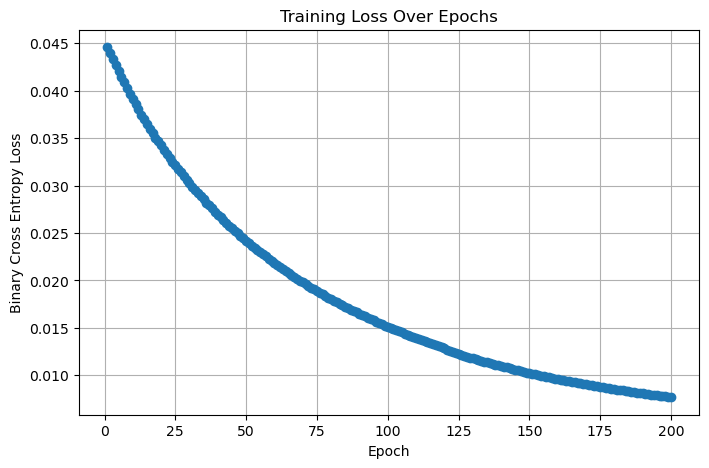

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, linestyle='--', marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.grid(True)
plt.show()

In [18]:
# predicting based on train set
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_train_pred = (y_train_pred > 0.5).float()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

confusion_matrix(y_train, y_train_pred)

array([[109,   0],
       [  0, 133]])

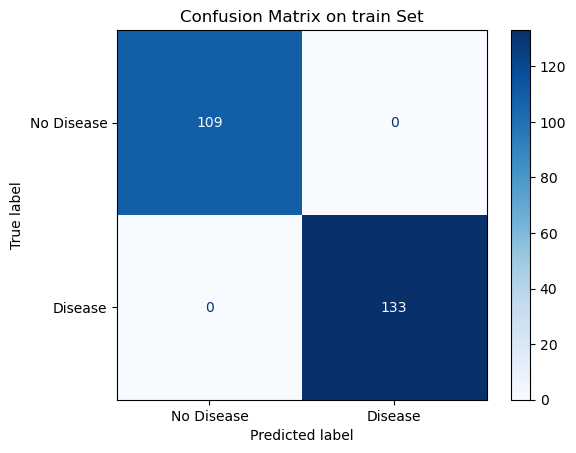

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on train Set")
plt.grid(False)
plt.show()


In [20]:
from sklearn.metrics import accuracy_score

# Put model in evaluation mode
model.eval()

# Turn off gradient tracking
with torch.no_grad():
    y_train_logits = model(X_train)
    y_train_probs = torch.sigmoid(y_train_logits)
    y_train_preds = (y_train_probs >= 0.5).float()  # threshold at 0.5

    # Compute test loss
    train_loss = loss_fn(y_train_logits, y_train)

# Accuracy
train_acc = accuracy_score(y_train.numpy(), y_train_preds.numpy())

print(f"Train Loss: {train_loss.item():.4f}")
print(f"Train Accuracy: {train_acc * 100:.2f}%")

Train Loss: 0.0077
Train Accuracy: 54.96%


**What This Tells Us**

A **smoothly decreasing loss** suggests that:

- The model is learning useful patterns from the training data
- The optimizer (Adam) and learning rate are appropriate
- We’re likely not underfitting or overfitting — yet


> 🔔 Later, we’ll compare this to the **test loss** and accuracy to see how well the model generalizes to unseen data.

➡️ Next: Let’s **evaluate the model** on the test set and analyze its performance!

---

## 🔧 Code Task 2.4.6.1: Evaluate Model on the Test Set (Loss and Accuracy)

You previously computed loss and accuracy on the **training** set.  
Now your task is to:

✅ Compute **test loss** using `loss_fn`  
✅ Compute **test accuracy** using a threshold of 0.5 on model probabilities  
✅ Use `model.eval()` and `torch.no_grad()` for evaluation  
✅ Store the test accuracy in a variable called `test_acc`  
✅ Store the test loss in a variable called `test_loss`

**Hint:** Use `X_test` and `y_test` as your input and target tensors.

In [21]:
from sklearn.metrics import accuracy_score

# Put the model in evaluation mode
model.eval()

# Turn off gradient tracking
with torch.no_grad():
    # TODO: Compute predictions for X_test
    # Use sigmoid, threshold at 0.5 to get binary labels
    # Then compute test_loss and test_acc
    test_logits = model(X_test)
    test_probs = torch.sigmoid(test_logits)
    test_preds = (test_probs > 0.5).float()
    test_loss = loss_fn(test_preds, y_test)
    test_acc = accuracy_score(y_test, test_preds)

# Final print
print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 24.5902
Test Accuracy: 75.41%


### **7. Evaluating the Model on Test Set**

Now that we’ve trained our neural network and visualized its training loss, let’s evaluate how well it performs on **unseen data** — the **test set**.

**Goals:**

- Compute **test loss**
- Measure **accuracy**
- Show a **confusion matrix**
- Interpret what the numbers mean

**Key Concept: Generalization**

> A good model should perform **well not just on training data**,  
> but also on **new, unseen test data**.

**Evaluate the Model**

In [22]:
# Put model in evaluation mode
model.eval()

# Turn off gradient tracking
with torch.no_grad():
    y_test_logits = model(X_test)
    y_test_probs = torch.sigmoid(y_test_logits)
    y_test_preds = (y_test_probs >= 0.5).float()  # threshold at 0.5

    # Compute test loss
    test_loss = loss_fn(y_test_logits, y_test)

# Accuracy
test_acc = accuracy_score(y_test.numpy(), y_test_preds.numpy())

print(f"Test Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 3.0174
Test Accuracy: 52.46%


**Confusion Matrix**

The **confusion matrix** shows how many samples were:

- **Correctly classified** (True Positives and True Negatives)
- **Incorrectly classified** (False Positives and False Negatives)

**Plot Confusion Matrix**

In [23]:
# predicting based on train set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

confusion_matrix(y_test, y_test_pred)

array([[25,  4],
       [ 5, 27]])

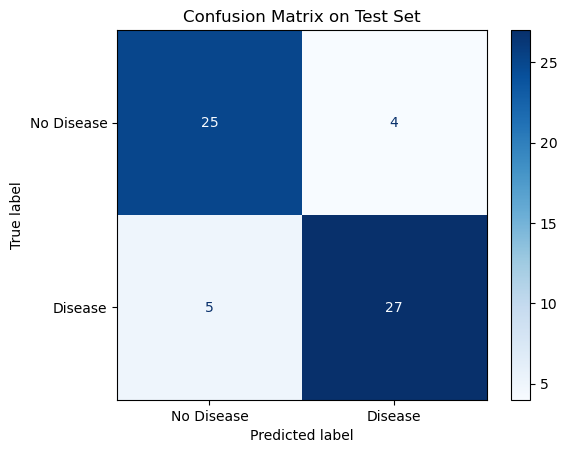

In [24]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

**Interpretation:**

- High values on the **diagonal** = good!
- Off-diagonal values suggest **misclassifications**
- This helps us understand **model strengths and weaknesses**

> ✅ If your model shows decent accuracy and balanced predictions, that means it has **learned to generalize** — not just memorize.

➡️ In the final section, we’ll reflect on the full process and look ahead to deeper models in the next project.

---

# Using the nn.Module Class

nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()

In [25]:
X_train.shape[1]

13

In [26]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[1], out_features=32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

custom_model = CustomModel()
print(custom_model)

CustomModel(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [27]:
sum(p.numel() for p in custom_model.parameters())

993

In [28]:
epochs = 200
lr = 0.01
optimizer = optim.Adam(custom_model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [29]:
print(type(loss_fn))

<class 'torch.nn.modules.loss.BCELoss'>


In [30]:
y_tesnor.shape

torch.Size([303, 1])

In [31]:
losses = []

for epoch in range(epochs):
    custom_model.train()

    # forward pass
    outputs = custom_model(X_train)
    loss = loss_fn(outputs, y_train)

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(F"Epoch: {epoch + 1}, Loss: {loss.item()}")

Epoch: 10, Loss: 0.42333054542541504
Epoch: 20, Loss: 0.3127221167087555
Epoch: 30, Loss: 0.25544583797454834
Epoch: 40, Loss: 0.20193465054035187
Epoch: 50, Loss: 0.141391322016716
Epoch: 60, Loss: 0.08120667189359665
Epoch: 70, Loss: 0.04018263891339302
Epoch: 80, Loss: 0.019900521263480186
Epoch: 90, Loss: 0.012257914990186691
Epoch: 100, Loss: 0.008994121104478836
Epoch: 110, Loss: 0.007764899637550116
Epoch: 120, Loss: 0.0071257599629461765
Epoch: 130, Loss: 0.006729772314429283
Epoch: 140, Loss: 0.00644108559936285
Epoch: 150, Loss: 0.006208233069628477
Epoch: 160, Loss: 0.005997607484459877
Epoch: 170, Loss: 0.005827276036143303
Epoch: 180, Loss: 0.005651782266795635
Epoch: 190, Loss: 0.00549069419503212
Epoch: 200, Loss: 0.005341050680726767


In [32]:
custom_model.eval()
with torch.no_grad():
    #train predict
    train_probs = custom_model(X_train)
    train_preds = (train_probs >= 0.5).float()
    
    test_probs = custom_model(X_test)
    test_preds = (test_preds >= 0.5).float()

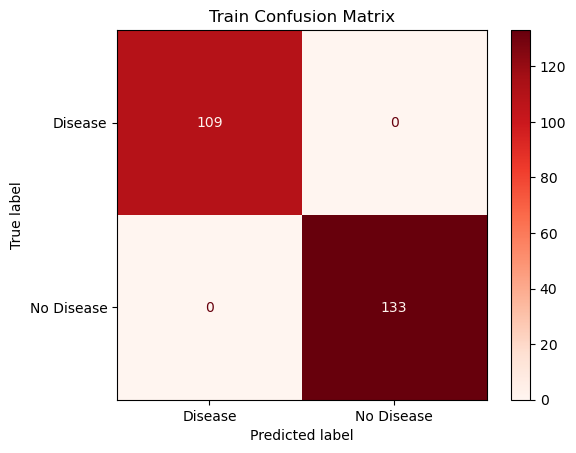

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_cm = confusion_matrix(train_preds.numpy(), y_train.numpy())
test_cm  = confusion_matrix(test_preds.numpy(), y_test.numpy())

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Disease', 'No Disease'])
disp_train.plot(cmap='Reds')
plt.title('Train Confusion Matrix')
plt.grid(False)
plt.show()

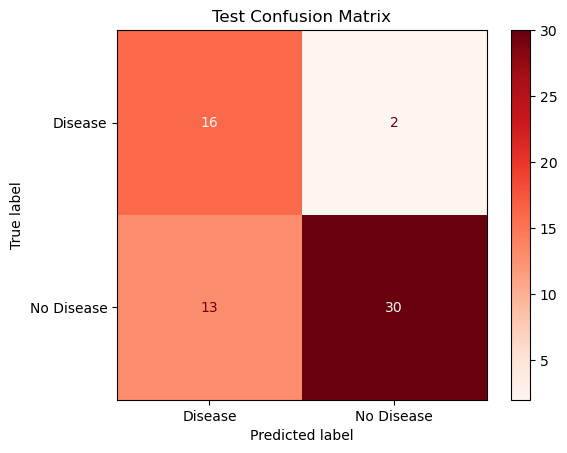

In [35]:
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Disease', 'No Disease'])
test_disp.plot(cmap='Reds')
plt.title('Test Confusion Matrix')
plt.grid(False)
plt.show();

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, test_preds)

0.7540983606557377

In [37]:
accuracy_score(y_train, train_preds)

1.0